
### Tutorial Objective          :  Get  a score 0.69 or more for this [Kaggle challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard) 


## Steps

1. Read Zhiding Yu's & Cha Zhang's paper [1] [Image based Static Facial Expression Recognition with Multiple Deep Network Learning](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/icmi2015_ChaZhang.pdf)
    - **It is very important to understand this paper**
    - We are going to implement the NN model and methods in this paper
2. Checkout this repo - [https://github.com/LamUong/FacialExpressionRecognition](https://github.com/LamUong/FacialExpressionRecognition)
    - it has lot of helper functions to read data
    - It has Simple Average Ensemble method
    - This code will save us a lot of time
3. Exploratory data analysis

4. Build a NN model based on Zhiding Yu's paper [1]
    - Use the basic CNN model given in the paper as a reference design
    - Try to improve the model by 
            - adding more layers
            - using different optimiser
            - using different cost function etc.
    - Use randomized peturbation for training(Data Augmentation)
    - Get as high testing accuracy as possible
    
5. Test with Private Leader Board data
6. Analyse the results of the stand alone model
    - print confusion matrix
    - plot validation/training accuracy/loss
7. Build Different ensemble models (using Randomly perturbed input) to increase further accuracy
    - Simple Average Ensembling
    - NN based Ensembling
8. Plot and Compare the results of different approaches
9. Choose the one with highest tesing accuracy
    - and pray it beats Kaggle scores ![Image](http://globe-views.com/dcim/dreams/smile/smile-01.jpg)


[1] Image based Static Facial Expression Recognition with Multiple Deep Network Learning


### Mre Details can be found here              :  https://github.com/LamUong/FacialExpressionRecognition

### Current Achieved Accuracy for the [Kaggle challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard) :  0.6825


## Some observaions
- test and validation accuracy seems to be very close (so the test accuracy will be almost same as validation accuracy)

**Notice** <br/>
Permission to make digital or hard copies of all or part of this work for personal or classroom use is granted without fee provided that copies are not made or distributed for profit or commercial advantage and that copies bear this notice and the full citation on the first page. Copyrights for components of this work owned by others than ACM must be honored. Abstracting with credit is permitted. To copy otherwise, or republish, to post on servers or to redistribute to lists, requires prior specific permission and/or a fee.

<br/> Request permissions from Permissions@acm.org.
<br/> EmotiW’15, November 9, 2015, Seattle, WA, USA.
<br/> 2015 ACM. ISBN 978-1-4503-3983-4/15/11 ...$15.00.
<br/> DOI: http://dx.doi.org/10.1145/2823327.2823341.

#### Some observaions

#### the test accuracy and private leader board accuracy are very close

#### after 300 trials there sees to have over fitting

In [2]:
from __future__ import print_function

import cv2
import PIL
from PIL import Image
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Conv2D
from keras.layers import AveragePooling2D
from keras.optimizers import Adadelta ,SGD 
from keras.utils import np_utils
#from keras.regularizers import l2, activity_l2
from keras.regularizers import l2, l1
from keras.layers import deserialize as layer_from_config
import numpy as np
import _pickle as cPickle
import numpy
import cv2
import scipy
import csv
import dataprocessing
from numpy import array

## Define the model

#### Custom cost function


In [3]:
import keras.backend as K

def categorical_crossentropy_svm(y_true, y_pred):
    alpha = 0.6
        
    ce_loss = K.categorical_crossentropy(y_true, y_pred)
    
    rmse_loss = K.sqrt(K.mean(K.square((y_pred - y_true)*(1 - y_true)), axis=-1))
    
    return (ce_loss + rmse_loss)

In [4]:
def model_generate():
    img_rows, img_cols = 48, 48

    model = Sequential()
    model.add(Convolution2D(128, kernel_size=(5, 5), padding='same', input_shape=(img_rows, img_cols, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(Convolution2D(128, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())  
    
    model.add(Convolution2D(128, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization()) 
    
    model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Convolution2D(128, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Convolution2D(128, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))
    model.add(Dropout(0.2))
    #model.add(Conv2D(512, 3, 3))
    #model.add(Activation('relu'))
    #model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))

    #ada = Adadelta(lr=0.1, rho=0.95, epsilon=1e-08)
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #adam = keras.optimizers.Adam()
    
    model.compile(loss=categorical_crossentropy_svm,
    optimizer=sgd,
    metrics=['accuracy'])
    
    model.summary()
    
    return model

In [5]:
model = model_generate()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 128)       3328      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 128)       0         
__________

### Load and preprocess the train and validation data

In [6]:
def get_train_test_data():
    
    X_train, y_train, X_test, y_test  = dataprocessing.load_data()
    
    for i in range(len(X_train)):
        X_train[i] = (array(X_train[i])).reshape(48, 48, 1)
        
    X_train= array(X_train)
    
    for i in range(len(X_test)):
        X_test[i] = (array(X_test[i])).reshape(48, 48, 1)
        
    X_test= array(X_test)
    
    y_train = array(y_train)
    y_test  = array(y_test)
    
    # Convert 1-dimensional class arrays to 10-dimensional class matrices
    Y_train = np_utils.to_categorical(y_train, 7)
    Y_test = np_utils.to_categorical(y_test, 7)
    
    return X_train, Y_train, X_test, Y_test

In [7]:
X_train, Y_train, X_test, Y_test = get_train_test_data()

In [8]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(32181, 48, 48, 1) (32181, 7) (3589, 48, 48, 1) (3589, 7)


In [23]:
#Callback for saving the best model
from keras.callbacks import ModelCheckpoint
filepath= "FaceExp_Reco_tr_08.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [24]:
batch_size = 128
nb_classes = 7

### Data Augmentation

In [25]:
#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='nearest')

### Train the model

In [26]:
'''model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)'''

model.fit_generator(datagen.flow(X_train, Y_train,
          batch_size=batch_size),
          epochs=100,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)

Epoch 1/100
252/252 [==============================] - 93s 368ms/step - loss: 1.9428 - acc: 0.2713 - val_loss: 1.8204 - val_acc: 0.3617

Epoch 00001: val_acc improved from -inf to 0.36166, saving model to FaceExp_Reco_tr_08.best.hdf5
Epoch 2/100
252/252 [==============================] - 34s 136ms/step - loss: 1.7525 - acc: 0.3623 - val_loss: 1.6694 - val_acc: 0.4023

Epoch 00002: val_acc improved from 0.36166 to 0.40234, saving model to FaceExp_Reco_tr_08.best.hdf5
Epoch 3/100
252/252 [==============================] - 34s 136ms/step - loss: 1.6386 - acc: 0.4162 - val_loss: 1.4539 - val_acc: 0.4987

Epoch 00003: val_acc improved from 0.40234 to 0.49875, saving model to FaceExp_Reco_tr_08.best.hdf5
Epoch 4/100
252/252 [==============================] - 34s 136ms/step - loss: 1.5684 - acc: 0.4470 - val_loss: 1.4303 - val_acc: 0.5063

Epoch 00004: val_acc improved from 0.49875 to 0.50627, saving model to FaceExp_Reco_tr_08.best.hdf5
Epoch 5/100
252/252 [==============================] - 

252/252 [==============================] - 35s 137ms/step - loss: 0.9290 - acc: 0.6910 - val_loss: 1.0208 - val_acc: 0.6693

Epoch 00079: val_acc improved from 0.66843 to 0.66927, saving model to FaceExp_Reco_tr_08.best.hdf5
Epoch 80/100
252/252 [==============================] - 35s 137ms/step - loss: 0.9189 - acc: 0.6983 - val_loss: 1.0527 - val_acc: 0.6670

Epoch 00080: val_acc did not improve from 0.66927
Epoch 81/100
252/252 [==============================] - 35s 137ms/step - loss: 0.9146 - acc: 0.6999 - val_loss: 1.0764 - val_acc: 0.6576

Epoch 00081: val_acc did not improve from 0.66927
Epoch 82/100
252/252 [==============================] - 35s 137ms/step - loss: 0.9161 - acc: 0.6986 - val_loss: 1.0419 - val_acc: 0.6659

Epoch 00082: val_acc did not improve from 0.66927
Epoch 83/100
252/252 [==============================] - 35s 137ms/step - loss: 0.9072 - acc: 0.7016 - val_loss: 1.0375 - val_acc: 0.6726

Epoch 00083: val_acc improved from 0.66927 to 0.67261, saving model to Fa

In [ ]:
'''model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)'''

model.fit_generator(datagen.flow(X_train, Y_train,
          batch_size=batch_size),
          epochs=100,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)

Epoch 1/100
252/252 [==============================] - 34s 135ms/step - loss: 0.8622 - acc: 0.7140 - val_loss: 1.1099 - val_acc: 0.6539

Epoch 00001: val_acc did not improve from 0.68710
Epoch 2/100
252/252 [==============================] - 34s 136ms/step - loss: 0.8667 - acc: 0.7156 - val_loss: 0.9966 - val_acc: 0.6829

Epoch 00002: val_acc did not improve from 0.68710
Epoch 3/100
252/252 [==============================] - 34s 136ms/step - loss: 0.8616 - acc: 0.7158 - val_loss: 1.0599 - val_acc: 0.6793

Epoch 00003: val_acc did not improve from 0.68710
Epoch 4/100
252/252 [==============================] - 34s 136ms/step - loss: 0.8596 - acc: 0.7184 - val_loss: 1.0455 - val_acc: 0.6765

Epoch 00004: val_acc did not improve from 0.68710
Epoch 5/100
252/252 [==============================] - 34s 137ms/step - loss: 0.8586 - acc: 0.7194 - val_loss: 1.0794 - val_acc: 0.6673

Epoch 00005: val_acc did not improve from 0.68710
Epoch 6/100
252/252 [==============================] - 34s 137ms/

In [33]:
from keras.models import load_model

new_model = load_model("FaceExp_Reco_tr_08.best.hdf5",custom_objects={'categorical_crossentropy_svm': categorical_crossentropy_svm})
score = new_model.evaluate(X_test, Y_test, verbose=1)
print('Public Leader Board Test loss:', score[0])
print('Public Leader Board Test accuracy:', score[1])
score = new_model.evaluate(X_train, Y_train, verbose=1)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

3589/3589 [==============================] - 4s 1ms/step
Private Leader Board Test loss: 0.6042264672533387
Private Leader Board Test accuracy: 0.6319309000053522
64362/64362 [==============================] - 72s 1ms/step
Private Leader Board Test loss: 0.5078736222859755
Private Leader Board Test accuracy: 0.6893819334389857


In [34]:
#Callback for saving the best model
from keras.callbacks import ModelCheckpoint
filepath= "FaceExp_Reco_tr_08.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [35]:
model = new_model

In [36]:
'''model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)'''

model.fit_generator(datagen.flow(X_train, Y_train,
          batch_size=batch_size),
          epochs=60,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)

Epoch 1/60
503/503 [==============================] - 165s 329ms/step - loss: 0.5857 - acc: 0.6379 - val_loss: 0.6804 - val_acc: 0.5957

Epoch 00001: val_acc improved from -inf to 0.59571, saving model to FaceExp_Reco_tr_07.best.hdf5
Epoch 2/60
503/503 [==============================] - 165s 328ms/step - loss: 0.5864 - acc: 0.6366 - val_loss: 0.6351 - val_acc: 0.6124

Epoch 00002: val_acc improved from 0.59571 to 0.61243, saving model to FaceExp_Reco_tr_07.best.hdf5
Epoch 3/60
503/503 [==============================] - 165s 328ms/step - loss: 0.5858 - acc: 0.6370 - val_loss: 0.6384 - val_acc: 0.6013

Epoch 00003: val_acc did not improve from 0.61243
Epoch 4/60
503/503 [==============================] - 165s 328ms/step - loss: 0.5851 - acc: 0.6372 - val_loss: 0.6609 - val_acc: 0.6077

Epoch 00004: val_acc did not improve from 0.61243
Epoch 5/60
503/503 [==============================] - 165s 328ms/step - loss: 0.5839 - acc: 0.6387 - val_loss: 0.6799 - val_acc: 0.5935

Epoch 00005: val_a

503/503 [==============================] - 165s 328ms/step - loss: 0.5425 - acc: 0.6640 - val_loss: 0.6061 - val_acc: 0.6353

Epoch 00043: val_acc improved from 0.63137 to 0.63527, saving model to FaceExp_Reco_tr_07.best.hdf5
Epoch 44/60
503/503 [==============================] - 165s 328ms/step - loss: 0.5429 - acc: 0.6661 - val_loss: 0.6388 - val_acc: 0.6216

Epoch 00044: val_acc did not improve from 0.63527
Epoch 45/60
503/503 [==============================] - 165s 328ms/step - loss: 0.5417 - acc: 0.6642 - val_loss: 0.6369 - val_acc: 0.6172

Epoch 00045: val_acc did not improve from 0.63527
Epoch 46/60
503/503 [==============================] - 165s 328ms/step - loss: 0.5384 - acc: 0.6671 - val_loss: 0.6256 - val_acc: 0.6291

Epoch 00046: val_acc did not improve from 0.63527
Epoch 47/60
503/503 [==============================] - 165s 328ms/step - loss: 0.5414 - acc: 0.6680 - val_loss: 0.6601 - val_acc: 0.6155

Epoch 00047: val_acc did not improve from 0.63527
Epoch 48/60
503/503 [=

In [ ]:
'''model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)'''

model.fit_generator(datagen.flow(X_train, Y_train,
          batch_size=batch_size),
          epochs=60,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)

Epoch 1/60
503/503 [==============================] - 164s 327ms/step - loss: 0.5247 - acc: 0.6782 - val_loss: 0.6477 - val_acc: 0.6225

Epoch 00001: val_acc did not improve from 0.63806
Epoch 2/60
503/503 [==============================] - 165s 328ms/step - loss: 0.5268 - acc: 0.6756 - val_loss: 0.6615 - val_acc: 0.6225

Epoch 00002: val_acc did not improve from 0.63806
Epoch 3/60
503/503 [==============================] - 165s 328ms/step - loss: 0.5261 - acc: 0.6767 - val_loss: 0.6459 - val_acc: 0.6275

Epoch 00003: val_acc did not improve from 0.63806
Epoch 4/60
503/503 [==============================] - 165s 328ms/step - loss: 0.5243 - acc: 0.6769 - val_loss: 0.6313 - val_acc: 0.6236

Epoch 00004: val_acc did not improve from 0.63806
Epoch 5/60
503/503 [==============================] - 165s 328ms/step - loss: 0.5239 - acc: 0.6775 - val_loss: 0.6939 - val_acc: 0.6160

Epoch 00005: val_acc did not improve from 0.63806
Epoch 6/60
503/503 [==============================] - 165s 328ms/

In [33]:
'''model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)'''

model.fit_generator(datagen.flow(X_train, Y_train,
          batch_size=batch_size),
          epochs=50,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)

Epoch 1/50
503/503 [==============================] - 77s 152ms/step - loss: 1.0500 - acc: 0.6046 - val_loss: 1.0224 - val_acc: 0.6149

Epoch 00001: val_acc improved from 0.61354 to 0.61493, saving model to FaceExp_Reco_tr_05.best.hdf5
Epoch 2/50
503/503 [==============================] - 77s 153ms/step - loss: 1.0461 - acc: 0.6039 - val_loss: 1.0436 - val_acc: 0.6099

Epoch 00002: val_acc did not improve from 0.61493
Epoch 3/50
503/503 [==============================] - 77s 152ms/step - loss: 1.0428 - acc: 0.6074 - val_loss: 1.0300 - val_acc: 0.6138

Epoch 00003: val_acc did not improve from 0.61493
Epoch 4/50
503/503 [==============================] - 77s 152ms/step - loss: 1.0408 - acc: 0.6072 - val_loss: 1.0371 - val_acc: 0.6135

Epoch 00004: val_acc did not improve from 0.61493
Epoch 5/50
503/503 [==============================] - 77s 152ms/step - loss: 1.0344 - acc: 0.6111 - val_loss: 1.0096 - val_acc: 0.6119

Epoch 00005: val_acc did not improve from 0.61493
Epoch 6/50
503/503 [

503/503 [==============================] - 77s 152ms/step - loss: 0.9382 - acc: 0.6482 - val_loss: 1.0032 - val_acc: 0.6330

Epoch 00044: val_acc did not improve from 0.63695
Epoch 45/50
503/503 [==============================] - 77s 152ms/step - loss: 0.9322 - acc: 0.6477 - val_loss: 1.0130 - val_acc: 0.6395

Epoch 00045: val_acc improved from 0.63695 to 0.63945, saving model to FaceExp_Reco_tr_05.best.hdf5
Epoch 46/50
503/503 [==============================] - 77s 152ms/step - loss: 0.9302 - acc: 0.6504 - val_loss: 0.9974 - val_acc: 0.6395

Epoch 00046: val_acc did not improve from 0.63945
Epoch 47/50
503/503 [==============================] - 77s 152ms/step - loss: 0.9277 - acc: 0.6523 - val_loss: 1.0353 - val_acc: 0.6311

Epoch 00047: val_acc did not improve from 0.63945
Epoch 48/50
503/503 [==============================] - 77s 152ms/step - loss: 0.9295 - acc: 0.6521 - val_loss: 1.0289 - val_acc: 0.6247

Epoch 00048: val_acc did not improve from 0.63945
Epoch 49/50
503/503 [======

In [34]:
'''model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)'''

model.fit_generator(datagen.flow(X_train, Y_train,
          batch_size=batch_size),
          epochs=100,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)

Epoch 1/100
503/503 [==============================] - 77s 152ms/step - loss: 0.9228 - acc: 0.6540 - val_loss: 1.0076 - val_acc: 0.6339

Epoch 00001: val_acc did not improve from 0.63945
Epoch 2/100
503/503 [==============================] - 77s 153ms/step - loss: 0.9165 - acc: 0.6555 - val_loss: 1.0273 - val_acc: 0.6297

Epoch 00002: val_acc did not improve from 0.63945
Epoch 3/100
503/503 [==============================] - 77s 153ms/step - loss: 0.9119 - acc: 0.6580 - val_loss: 1.0558 - val_acc: 0.6241

Epoch 00003: val_acc did not improve from 0.63945
Epoch 4/100
503/503 [==============================] - 77s 153ms/step - loss: 0.9106 - acc: 0.6585 - val_loss: 1.0188 - val_acc: 0.6294

Epoch 00004: val_acc did not improve from 0.63945
Epoch 5/100
503/503 [==============================] - 77s 153ms/step - loss: 0.9132 - acc: 0.6577 - val_loss: 1.0402 - val_acc: 0.6205

Epoch 00005: val_acc did not improve from 0.63945
Epoch 6/100
503/503 [==============================] - 77s 153ms/

503/503 [==============================] - 77s 152ms/step - loss: 0.7549 - acc: 0.7198 - val_loss: 1.0825 - val_acc: 0.6383

Epoch 00086: val_acc did not improve from 0.65561
Epoch 87/100
503/503 [==============================] - 77s 152ms/step - loss: 0.7549 - acc: 0.7192 - val_loss: 1.0724 - val_acc: 0.6509

Epoch 00087: val_acc did not improve from 0.65561
Epoch 88/100
503/503 [==============================] - 77s 152ms/step - loss: 0.7574 - acc: 0.7187 - val_loss: 1.0637 - val_acc: 0.6506

Epoch 00088: val_acc did not improve from 0.65561
Epoch 89/100
503/503 [==============================] - 77s 152ms/step - loss: 0.7465 - acc: 0.7233 - val_loss: 1.1360 - val_acc: 0.6250

Epoch 00089: val_acc did not improve from 0.65561
Epoch 90/100
503/503 [==============================] - 77s 153ms/step - loss: 0.7473 - acc: 0.7214 - val_loss: 1.1269 - val_acc: 0.6330

Epoch 00090: val_acc did not improve from 0.65561
Epoch 91/100
503/503 [==============================] - 77s 152ms/step - 


## We have done enough training. It is not good enough. However, let's check how the model performs on Private leader board data.

#### Load and process Private leader board data

In [35]:
X_private_test, y_private_test  = dataprocessing.load_test_data()

In [36]:
for i in range(len(X_private_test)):
    X_private_test[i] = (array(X_private_test[i])).reshape(48, 48, 1)

In [37]:
X_private_test= array(X_private_test)
X_private_test.shape

(3589, 48, 48, 1)

In [38]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_private_test = np_utils.to_categorical(y_private_test, 7)

## Evaluate your model on Private Leader board data

In [39]:
model.evaluate(X_private_test, Y_private_test)

3589/3589 [==============================] - 2s 554us/step


[1.1139675975344114, 0.6419615492112593]

In [53]:
from keras.models import load_model

new_model = load_model("FaceExp_Reco_tr_08.best.hdf5")
score = new_model.evaluate(X_private_test, Y_private_test, verbose=1)
print('Private Leader Board Test loss:', score[0])
print('Private Leader Board Test accuracy:', score[1])

3589/3589 [==============================] - 3s 706us/step
Private Leader Board Test loss: 1.0390912640988246
Private Leader Board Test accuracy: 0.6556143772804693


## Let's Train the model for a few more epochs and see if things improve

### Looks like the model is overtfitting let's  increase the dropot and see if it helps the model

In [70]:
def model_generate():
    img_rows, img_cols = 48, 48
    dropout_rate = 0.5

    model = Sequential()
    model.add(Convolution2D(64, 5, 5, border_mode='valid', input_shape=(img_rows, img_cols, 1)))
    model.add(BatchNormalization())
    model.add(keras.layers.advanced_activations.PReLU(init='zero', weights=None))
    model.add(Convolution2D(64, 3, 3))
    model.add(BatchNormalization())
    model.add(keras.layers.advanced_activations.PReLU(init='zero', weights=None))
    #model.add(keras.layers.convolutional.ZeroPadding2D(padding=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(keras.layers.convolutional.ZeroPadding2D(padding=(1, 1)))
    model.add(Convolution2D(64, 3, 3))
    model.add(BatchNormalization())
    model.add(keras.layers.advanced_activations.PReLU(init='zero', weights=None))
    #model.add(keras.layers.convolutional.ZeroPadding2D(padding=(1, 1))) 
    model.add(Convolution2D(64, 3, 3))
    model.add(BatchNormalization())
    model.add(keras.layers.advanced_activations.PReLU(init='zero', weights=None))
    model.add(keras.layers.convolutional.AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))

    #model.add(keras.layers.convolutional.ZeroPadding2D(padding=(1, 1)))
    model.add(Convolution2D(256, 3, 3))
    model.add(BatchNormalization())
    model.add(keras.layers.advanced_activations.PReLU(init='zero', weights=None))
    #model.add(keras.layers.convolutional.ZeroPadding2D(padding=(1, 1)))
    model.add(Convolution2D(512, 3, 3))
    model.add(BatchNormalization())
    model.add(keras.layers.advanced_activations.PReLU(init='zero', weights=None))
 
    #model.add(keras.layers.convolutional.ZeroPadding2D(padding=(1, 1)))
    model.add(keras.layers.convolutional.AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))
 
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(keras.layers.advanced_activations.PReLU(init='zero', weights=None))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1024))
    model.add(keras.layers.advanced_activations.PReLU(init='zero', weights=None))
    model.add(Dropout(dropout_rate))

    model.add(Dense(7))
    model.add(Activation('softmax'))

    ada = Adadelta(lr=0.01, rho=0.95, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
    optimizer=ada,
    metrics=['accuracy'])
    model.summary()
    return model

In [71]:
model_spin_01 = model_generate()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(48, 48, 1..., padding="valid")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(weights=None, alpha_initializer="zero")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(weights=None, alpha_initializer="zero")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 44, 44, 64)        1664      
_________________________________________________________________
batch_normalization_25 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
p_re_lu_33 (PReLU)           (None, 44, 44, 64)        123904    
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 42, 42, 64)        36928     
_________________________________________________________________
batch_normalization_26 (Batc (None, 42, 42, 64)        256       
_________________________________________________________________
p_re_lu_34 (PReLU)           (None, 42, 42, 64)        112896    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 21, 21, 64)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(weights=None, alpha_initializer="zero")`


In [72]:
from keras.models import load_model

model_spin_01 = load_model("FaceExp_Reco_tr_05.best.hdf5")
score = model_spin_01.evaluate(X_private_test, Y_private_test, verbose=1)
print('Private Leader Board Test loss:', score[0])
print('Private Leader Board Test accuracy:', score[1])

3589/3589 [==============================] - 3s 816us/step
Private Leader Board Test loss: 1.0390912640988246
Private Leader Board Test accuracy: 0.6556143772804693


In [73]:
model_spin_01.fit_generator(datagen.flow(X_train, Y_train,
          batch_size=batch_size),
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)

Epoch 1/10
503/503 [==============================] - 79s 157ms/step - loss: 0.7749 - acc: 0.7120 - val_loss: 1.1158 - val_acc: 0.6397

Epoch 00001: val_acc did not improve from 0.65561
Epoch 2/10
503/503 [==============================] - 78s 155ms/step - loss: 0.7712 - acc: 0.7116 - val_loss: 1.0607 - val_acc: 0.6464

Epoch 00002: val_acc did not improve from 0.65561
Epoch 3/10
503/503 [==============================] - 78s 154ms/step - loss: 0.7715 - acc: 0.7128 - val_loss: 1.0817 - val_acc: 0.6317

Epoch 00003: val_acc did not improve from 0.65561
Epoch 4/10
503/503 [==============================] - 78s 154ms/step - loss: 0.7672 - acc: 0.7144 - val_loss: 1.0711 - val_acc: 0.6378

Epoch 00004: val_acc did not improve from 0.65561
Epoch 5/10
503/503 [==============================] - 77s 154ms/step - loss: 0.7707 - acc: 0.7117 - val_loss: 1.0748 - val_acc: 0.6417

Epoch 00005: val_acc did not improve from 0.65561
Epoch 6/10
503/503 [==============================] - 77s 154ms/step -

In [74]:
model_spin_01.fit_generator(datagen.flow(X_train, Y_train,
          batch_size=batch_size),
          epochs=20,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)

Epoch 1/20
503/503 [==============================] - 78s 154ms/step - loss: 0.7538 - acc: 0.7191 - val_loss: 1.1454 - val_acc: 0.6252

Epoch 00001: val_acc did not improve from 0.65561
Epoch 2/20
503/503 [==============================] - 77s 154ms/step - loss: 0.7551 - acc: 0.7200 - val_loss: 1.1545 - val_acc: 0.6375

Epoch 00002: val_acc did not improve from 0.65561
Epoch 3/20
503/503 [==============================] - 77s 154ms/step - loss: 0.7526 - acc: 0.7209 - val_loss: 1.0991 - val_acc: 0.6319

Epoch 00003: val_acc did not improve from 0.65561
Epoch 4/20
503/503 [==============================] - 78s 155ms/step - loss: 0.7512 - acc: 0.7210 - val_loss: 1.1217 - val_acc: 0.6308

Epoch 00004: val_acc did not improve from 0.65561
Epoch 5/20
503/503 [==============================] - 78s 154ms/step - loss: 0.7504 - acc: 0.7187 - val_loss: 1.0916 - val_acc: 0.6395

Epoch 00005: val_acc did not improve from 0.65561
Epoch 6/20
503/503 [==============================] - 78s 154ms/step -

In [75]:
model_spin_01.fit_generator(datagen.flow(X_train, Y_train,
          batch_size=batch_size),
          epochs=30,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)

Epoch 1/30
503/503 [==============================] - 77s 154ms/step - loss: 0.7237 - acc: 0.7307 - val_loss: 1.2273 - val_acc: 0.6230

Epoch 00001: val_acc did not improve from 0.65561
Epoch 2/30
503/503 [==============================] - 78s 154ms/step - loss: 0.7216 - acc: 0.7316 - val_loss: 1.1208 - val_acc: 0.6467

Epoch 00002: val_acc did not improve from 0.65561
Epoch 3/30
503/503 [==============================] - 77s 154ms/step - loss: 0.7208 - acc: 0.7311 - val_loss: 1.1249 - val_acc: 0.6406

Epoch 00003: val_acc did not improve from 0.65561
Epoch 4/30
503/503 [==============================] - 78s 154ms/step - loss: 0.7275 - acc: 0.7304 - val_loss: 1.1808 - val_acc: 0.6364

Epoch 00004: val_acc did not improve from 0.65561
Epoch 5/30
503/503 [==============================] - 77s 154ms/step - loss: 0.7206 - acc: 0.7335 - val_loss: 1.1330 - val_acc: 0.6406

Epoch 00005: val_acc did not improve from 0.65561
Epoch 6/30
503/503 [==============================] - 77s 154ms/step -

### Evaluate the model again

In [77]:
score = model_spin_01.evaluate(X_private_test, Y_private_test, verbose=1)
print('Private Leader Board Test loss:', score[0])
print('Private Leader Board Test accuracy:', score[1])

3589/3589 [==============================] - 2s 574us/step
Private Leader Board Test loss: 1.168666683538075
Private Leader Board Test accuracy: 0.6430760657730857


In [78]:
from keras.models import load_model

new_model = load_model("FaceExp_Reco_tr_05.best.hdf5")
score = new_model.evaluate(X_private_test, Y_private_test, verbose=1)
print('Private Leader Board Test loss:', score[0])
print('Private Leader Board Test accuracy:', score[1])

3589/3589 [==============================] - 3s 842us/step
Private Leader Board Test loss: 1.0390912640988246
Private Leader Board Test accuracy: 0.6556143772804693


### Let's analyze the results in detail

#### check how the model performed on various classes

In [79]:
Y_private_pred = new_model.predict_proba(X_private_test)

In [87]:
Y_private_pred1 = model_spin_01.predict_proba(X_private_test)

In [91]:
from sklearn.metrics import confusion_matrix

In [108]:
y_true = []
y_pred = []

for row in Y_private_test:
    a = numpy.argmax(row) #return the indices of the maximum values along the axis
    y_true.append(a)
    
for row in Y_private_pred:
    a = numpy.argmax(row) #return the indices of the maximum values along the axis
    y_pred.append(a)

In [111]:
print(y_true)

[0, 5, 6, 4, 2, 0, 4, 3, 0, 3, 5, 3, 4, 4, 0, 6, 2, 5, 4, 2, 3, 6, 0, 6, 3, 2, 5, 6, 6, 3, 4, 6, 6, 0, 1, 3, 5, 0, 0, 4, 6, 4, 2, 4, 2, 4, 3, 6, 3, 3, 4, 2, 3, 2, 0, 4, 3, 6, 6, 2, 6, 4, 6, 3, 0, 0, 3, 5, 6, 0, 2, 5, 5, 6, 3, 0, 6, 0, 5, 3, 2, 3, 5, 6, 3, 4, 6, 2, 3, 3, 3, 2, 4, 6, 6, 4, 4, 5, 4, 6, 5, 3, 6, 6, 3, 4, 5, 5, 5, 3, 0, 3, 0, 0, 3, 3, 3, 3, 3, 0, 6, 3, 5, 4, 4, 0, 4, 3, 3, 3, 6, 3, 2, 0, 5, 0, 6, 6, 3, 0, 2, 3, 3, 4, 0, 6, 5, 6, 4, 2, 6, 6, 6, 6, 6, 5, 0, 0, 6, 3, 4, 5, 3, 2, 6, 2, 0, 0, 3, 6, 3, 5, 0, 3, 4, 0, 6, 2, 1, 6, 4, 6, 6, 0, 0, 6, 5, 2, 4, 1, 3, 2, 6, 3, 6, 2, 5, 0, 2, 3, 2, 4, 2, 4, 4, 6, 2, 2, 0, 2, 6, 6, 5, 0, 0, 5, 6, 3, 6, 6, 2, 2, 5, 5, 4, 3, 2, 1, 5, 3, 3, 6, 5, 1, 2, 2, 0, 5, 3, 6, 2, 4, 0, 3, 5, 3, 3, 4, 1, 6, 4, 0, 0, 2, 4, 5, 3, 3, 3, 3, 3, 0, 3, 6, 4, 2, 6, 4, 2, 6, 3, 2, 3, 4, 4, 3, 3, 0, 6, 6, 0, 4, 4, 6, 4, 4, 0, 6, 5, 6, 2, 4, 3, 4, 4, 0, 3, 3, 0, 6, 5, 0, 0, 0, 4, 0, 4, 6, 6, 3, 6, 6, 0, 5, 4, 4, 3, 6, 4, 0, 3, 2, 6, 2, 0, 2, 3, 6, 4, 3, 3, 3, 5, 

In [128]:
#confusion_matrix(y_true, y_pred, labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise'])

confusion_matrix(y_true, y_pred)

array([[260,   6,  60,  21,  82,  10,  52],
       [ 11,  36,   1,   3,   2,   1,   1],
       [ 47,   2, 236,  27, 104,  54,  58],
       [ 21,   0,  24, 764,  19,  15,  36],
       [ 63,   1,  64,  39, 315,   7, 105],
       [ 16,   0,  25,  26,   9, 325,  15],
       [ 26,   3,  33,  33,  98,  16, 417]])

In [125]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.52953157 0.01221996 0.12219959 0.04276986 0.16700611 0.0203666
  0.10590631]
 [0.2        0.65454545 0.01818182 0.05454545 0.03636364 0.01818182
  0.01818182]
 [0.08901515 0.00378788 0.4469697  0.05113636 0.1969697  0.10227273
  0.10984848]
 [0.02389078 0.         0.02730375 0.86916951 0.02161547 0.01706485
  0.04095563]
 [0.10606061 0.0016835  0.10774411 0.06565657 0.53030303 0.01178451
  0.17676768]
 [0.03846154 0.         0.06009615 0.0625     0.02163462 0.78125
  0.03605769]
 [0.04153355 0.00479233 0.05271565 0.05271565 0.15654952 0.02555911
  0.66613419]]


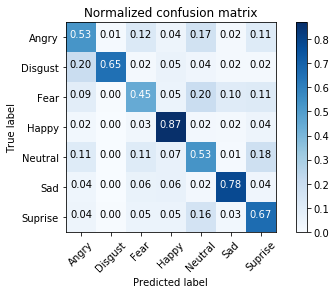

In [129]:
cnf_matrix     = confusion_matrix(y_true, y_pred)
class_names    = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [130]:
X_pred = new_model.predict_proba(X_train)


In [131]:
y_true = []
y_pred = []

for row in Y_train:
    a = numpy.argmax(row) #return the indices of the maximum values along the axis
    y_true.append(a)
    
for row in X_pred:
    a = numpy.argmax(row) #return the indices of the maximum values along the axis
    y_pred.append(a)

Normalized confusion matrix
[[6.76874578e-01 6.30488629e-03 7.40824139e-02 3.08489079e-02
  1.02679577e-01 1.32852961e-02 9.59243414e-02]
 [9.57230143e-02 7.71894094e-01 3.25865580e-02 2.85132383e-02
  5.49898167e-02 8.14663951e-03 8.14663951e-03]
 [6.66812418e-02 1.96764320e-03 6.23087014e-01 3.21381723e-02
  1.41451683e-01 5.94665501e-02 7.52076957e-02]
 [6.92383778e-03 1.23639960e-04 8.65479723e-03 9.33110781e-01
  7.78931751e-03 1.19930762e-02 3.14045500e-02]
 [5.23809524e-02 2.19780220e-03 8.20512821e-02 2.83882784e-02
  6.86263736e-01 9.15750916e-03 1.39560440e-01]
 [1.25874126e-02 1.67832168e-03 5.65034965e-02 3.77622378e-02
  1.45454545e-02 8.63216783e-01 1.37062937e-02]
 [2.88184438e-02 3.60230548e-04 3.40417867e-02 5.70965418e-02
  9.52809798e-02 9.90634006e-03 7.74495677e-01]]


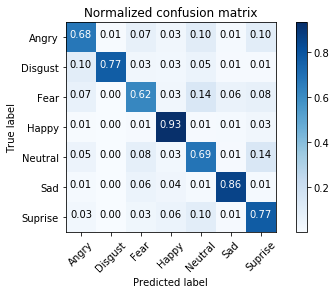

In [132]:
cnf_matrix     = confusion_matrix(y_true, y_pred)
class_names    = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

(array([ 8882.,   982.,     0.,  9148.,     0., 16176., 10920.,     0.,
         7150., 11104.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

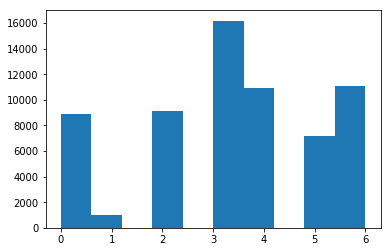

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline  



plt.hist(y_true)

(array([491.,  55.,   0., 528.,   0., 879., 594.,   0., 416., 626.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

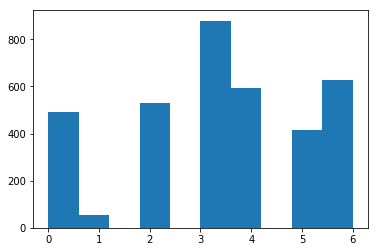

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline  



plt.hist(y_true)

In [120]:
np.histogram(y_true)

(array([491,  55,   0, 528,   0, 879, 594,   0, 416, 626]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]))

### Let's Train some more

(array([444.,  48.,   0., 443.,   0., 913., 629.,   0., 428., 684.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

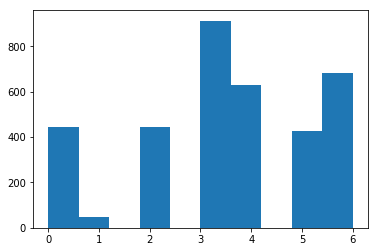

In [118]:
plt.hist(y_pred)

In [39]:
model.fit_generator(datagen.flow(X_train, Y_train,
          batch_size=batch_size),
          epochs=50,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=callbacks_list)

Epoch 1/50
503/503 [==============================] - 42s 83ms/step - loss: 0.8977 - acc: 0.6648 - val_loss: 1.0011 - val_acc: 0.6408

Epoch 00001: val_acc did not improve from 0.64280
Epoch 2/50
503/503 [==============================] - 42s 83ms/step - loss: 0.8962 - acc: 0.6637 - val_loss: 1.0271 - val_acc: 0.6317

Epoch 00002: val_acc did not improve from 0.64280
Epoch 3/50
503/503 [==============================] - 42s 83ms/step - loss: 0.8927 - acc: 0.6657 - val_loss: 1.0402 - val_acc: 0.6305

Epoch 00003: val_acc did not improve from 0.64280
Epoch 4/50
503/503 [==============================] - 42s 83ms/step - loss: 0.8898 - acc: 0.6689 - val_loss: 1.0175 - val_acc: 0.6303

Epoch 00004: val_acc did not improve from 0.64280
Epoch 5/50
503/503 [==============================] - 42s 83ms/step - loss: 0.8984 - acc: 0.6635 - val_loss: 1.0075 - val_acc: 0.6383

Epoch 00005: val_acc did not improve from 0.64280
Epoch 6/50
503/503 [==============================] - 42s 83ms/step - loss:

503/503 [==============================] - 42s 83ms/step - loss: 0.8629 - acc: 0.6771 - val_loss: 1.0240 - val_acc: 0.6364

Epoch 00045: val_acc did not improve from 0.64447
Epoch 46/50
503/503 [==============================] - 42s 83ms/step - loss: 0.8650 - acc: 0.6783 - val_loss: 1.0162 - val_acc: 0.6386

Epoch 00046: val_acc did not improve from 0.64447
Epoch 47/50
503/503 [==============================] - 42s 83ms/step - loss: 0.8647 - acc: 0.6758 - val_loss: 1.0081 - val_acc: 0.6353

Epoch 00047: val_acc did not improve from 0.64447
Epoch 48/50
503/503 [==============================] - 42s 83ms/step - loss: 0.8623 - acc: 0.6775 - val_loss: 1.0512 - val_acc: 0.6339

Epoch 00048: val_acc did not improve from 0.64447
Epoch 49/50
503/503 [==============================] - 42s 83ms/step - loss: 0.8598 - acc: 0.6817 - val_loss: 1.0367 - val_acc: 0.6311

Epoch 00049: val_acc did not improve from 0.64447
Epoch 50/50
503/503 [==============================] - 42s 83ms/step - loss: 0.857

In [40]:
score = model.evaluate(X_private_test, Y_private_test, verbose=1)
print('Private Leader Board Test loss:', score[0])
print('Private Leader Board Test accuracy:', score[1])


3589/3589 [==============================] - 1s 285us/step
Private Leader Board Test loss: 1.0101975353357353
Private Leader Board Test accuracy: 0.6425188075004763


In [41]:
from keras.models import load_model

new_model = load_model("FaceExp_Reco_tr_02.best.hdf5")
score = new_model.evaluate(X_private_test, Y_private_test, verbose=1)
print('Private Leader Board Test loss:', score[0])
print('Private Leader Board Test accuracy:', score[1])

3589/3589 [==============================] - 1s 353us/step
Private Leader Board Test loss: 0.9955075966444943
Private Leader Board Test accuracy: 0.644469211512736


#### Looks like it is overfitting

In [28]:
from keras.models import load_model

new_model = load_model("FaceExp_Reco_tr_02.best.hdf5")
score = new_model.evaluate(X_private_test, Y_private_test, verbose=1)
print('Private Leader Board Test loss:', score[0])
print('Private Leader Board Test accuracy:', score[1])

3589/3589 [==============================] - 47s 13ms/step
Private Leader Board Test loss: 0.9955075966444943
Private Leader Board Test accuracy: 0.644469211512736


In [29]:
from keras.models import load_model

new_model = load_model("FaceExp_Reco_tr_02.best.hdf5")
score = new_model.evaluate(X_private_test, Y_private_test, verbose=1)
print('Private Leader Board Test loss:', score[0])
print('Private Leader Board Test accuracy:', score[1])

3589/3589 [==============================] - 1s 316us/step
Private Leader Board Test loss: 0.9955075966444943
Private Leader Board Test accuracy: 0.644469211512736


### Ensembling method

In [42]:
private_set_x, private_set_y = dataprocessing.load_test_data()

In [43]:
def predict_prob(number,test_set_x,model):
    data_p = []
    for data in test_set_x:
        if number ==0:
            data_p.append(dataprocessing.Flip(data))
        elif number ==1:
            data_p.append(dataprocessing.Roated15Left(data))
        elif number ==2:
            data_p.append(dataprocessing.Roated15Right(data))
        elif number ==3:
            data_p.append(dataprocessing.shiftedUp20(data))
        elif number ==4:
            data_p.append(dataprocessing.shiftedDown20(data))
        elif number ==5:
            data_p.append(dataprocessing.shiftedLeft20(data))
        elif number ==6:
            data_p.append(dataprocessing.shiftedRight20(data))
        elif number ==7:
            data_p.append(data)
    
    #Covert the data to Numpy format
    for i in range(len(data_p)):
        data_p[i] = (array(data_p[i])).reshape(48, 48, 1)
        
    X_private_test= array(data_p)
            
    proba = model.predict_proba(X_private_test)
    return proba

In [60]:
model = model

proba0 = predict_prob(0, private_set_x, model)
proba1 = predict_prob(1, private_set_x, model)
proba2 = predict_prob(2, private_set_x, model)
proba3 = predict_prob(3, private_set_x, model)
proba4 = predict_prob(4, private_set_x, model)
proba5 = predict_prob(5, private_set_x, model)
proba6 = predict_prob(6, private_set_x, model)
proba7 = predict_prob(7, private_set_x, model)

In [61]:
Out = []
for row in zip(proba0,proba1,proba2,proba3,proba4,proba5,proba6,proba7):
    a = numpy.argmax(np.array(row).mean(axis=0)) #return the indices of the maximum values along the axis
    Out.append(a)

In [62]:
Out = np.array(Out)
private_set_y = np.array(private_set_y)

In [63]:
c = np.sum(Out == private_set_y)

### Accuracy for the averaging method

In [64]:
print("Acc:"+str((float(c)/len(Out))))

Acc:0.6753970465310671


### Let's analyze the results we got so far in detail

In [49]:
def evluate_ensemble(number,test_set_x,model, Y_private_test):
    data_p = []
    for data in test_set_x:
        if number ==0:
            data_p.append(dataprocessing.Flip(data))
        elif number ==1:
            data_p.append(dataprocessing.Roated15Left(data))
        elif number ==2:
            data_p.append(dataprocessing.Roated15Right(data))
        elif number ==3:
            data_p.append(dataprocessing.shiftedUp20(data))
        elif number ==4:
            data_p.append(dataprocessing.shiftedDown20(data))
        elif number ==5:
            data_p.append(dataprocessing.shiftedLeft20(data))
        elif number ==6:
            data_p.append(dataprocessing.shiftedRight20(data))
        elif number ==7:
            data_p.append(data)
    
    #Covert the data to Numpy format
    for i in range(len(data_p)):
        data_p[i] = (array(data_p[i])).reshape(48, 48, 1)
        
    X_private_test= array(data_p)

    score = model.evaluate(X_private_test, Y_private_test, verbose=1)
    print('Private Leader Board Test loss:', score[0])
    print('Private Leader Board Test accuracy:', score[1])
    return

In [54]:
model = new_model

proba0 = evluate_ensemble(0, private_set_x, model, Y_private_test)
proba1 = evluate_ensemble(1, private_set_x, model, Y_private_test)
proba2 = evluate_ensemble(2, private_set_x, model, Y_private_test)
proba3 = evluate_ensemble(3, private_set_x, model, Y_private_test)
proba4 = evluate_ensemble(4, private_set_x, model, Y_private_test)
proba5 = evluate_ensemble(5, private_set_x, model, Y_private_test)
proba6 = evluate_ensemble(6, private_set_x, model, Y_private_test)
proba7 = evluate_ensemble(7, private_set_x, model, Y_private_test)

3589/3589 [==============================] - 2s 553us/step
Private Leader Board Test loss: 1.0364213642485463
Private Leader Board Test accuracy: 0.6464196155249956
3589/3589 [==============================] - 2s 550us/step
Private Leader Board Test loss: 1.0000975849436464
Private Leader Board Test accuracy: 0.6408470326079138
3589/3589 [==============================] - 2s 550us/step
Private Leader Board Test loss: 1.029745809644602
Private Leader Board Test accuracy: 0.6383393703147408
3589/3589 [==============================] - 2s 546us/step
Private Leader Board Test loss: 1.0529486899689466
Private Leader Board Test accuracy: 0.6349958205794385
3589/3589 [==============================] - 2s 546us/step
Private Leader Board Test loss: 1.1011720207590152
Private Leader Board Test accuracy: 0.6246865422123155
3589/3589 [==============================] - 2s 546us/step
Private Leader Board Test loss: 1.0393270638933019
Private Leader Board Test accuracy: 0.640568403471609
3589/3589 [=

In [ ]:
Out = []
for row in zip(proba0,proba1,proba2,proba3,proba4,proba5,proba6,proba7):
    a = numpy.argmax(np.array(row).mean(axis=0)) #return the indices of the maximum values along the axis
    Out.append(a)